# 📨 Spam Email Classifier (SEC)


In [1]:
import os
import gdown
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from textblob import Word
from nltk.corpus import stopwords

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, mean_squared_error

nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/jovyan/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

## Downloading the dataset

In [2]:
outpout_dir = 'data'
os.makedirs(outpout_dir, exist_ok=True)

url = "https://drive.google.com/file/d/1wtogytIpZC74Tq6s1GWaPWY3VBhmOrJy/view?usp=sharing"
output = "data/spam_emails_1.csv"

gdown.download(url, output, quiet=False , fuzzy=True)

Downloading...
From: https://drive.google.com/uc?id=1wtogytIpZC74Tq6s1GWaPWY3VBhmOrJy
To: /app/src/data/spam_emails_1.csv
100%|██████████| 5.50M/5.50M [00:00<00:00, 56.3MB/s]


'data/spam_emails_1.csv'

In [3]:
%pip list | grep greate-expectations

Note: you may need to restart the kernel to use updated packages.


## Data Exploration
In this section, we will explore the dataset to get a better understanding of the data.

In [70]:
df = pd.read_csv('data/spam_emails_1.csv')
df.head()

,Unnamed: 0,label,text,label_num
0,605,ham,Subject: enron methanol ; meter # : 988291\r\n...,0
1,2349,ham,"Subject: hpl nom for january 9 , 2001\r\n( see...",0
2,3624,ham,"Subject: neon retreat\r\nho ho ho , we ' re ar...",0
3,4685,spam,"Subject: photoshop , windows , office . cheap ...",1
4,2030,ham,Subject: re : indian springs\r\nthis deal is t...,0


In [107]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5171 entries, 0 to 5170
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   label   5171 non-null   int64 
 1   text    5171 non-null   object
dtypes: int64(1), object(1)
memory usage: 80.9+ KB


The dataset contains 5, 171 emails. Each email has the following attributes:

- `text`: The text of the email
- `label`: The label of the email. `1` means the email is spam, `0` means the email is not spam.

### Cleaning the data

In [71]:
df.drop('Unnamed: 0', axis=1, inplace=True)
df.drop('label_num', axis=1, inplace=True)
df.head()

,label,text
0,ham,Subject: enron methanol ; meter # : 988291\r\n...
1,ham,"Subject: hpl nom for january 9 , 2001\r\n( see..."
2,ham,"Subject: neon retreat\r\nho ho ho , we ' re ar..."
3,spam,"Subject: photoshop , windows , office . cheap ..."
4,ham,Subject: re : indian springs\r\nthis deal is t...


In [72]:
label = {'ham': 0, 'spam': 1}
df['label'] = df['label'].map(label)
df.head()

,label,text
0,0,Subject: enron methanol ; meter # : 988291\r\n...
1,0,"Subject: hpl nom for january 9 , 2001\r\n( see..."
2,0,"Subject: neon retreat\r\nho ho ho , we ' re ar..."
3,1,"Subject: photoshop , windows , office . cheap ..."
4,0,Subject: re : indian springs\r\nthis deal is t...


In [108]:
df['label'].value_counts()

0    3672
1    1499
Name: label, dtype: int64

Text(0.5, 1.0, 'Number of ham and spam messages')

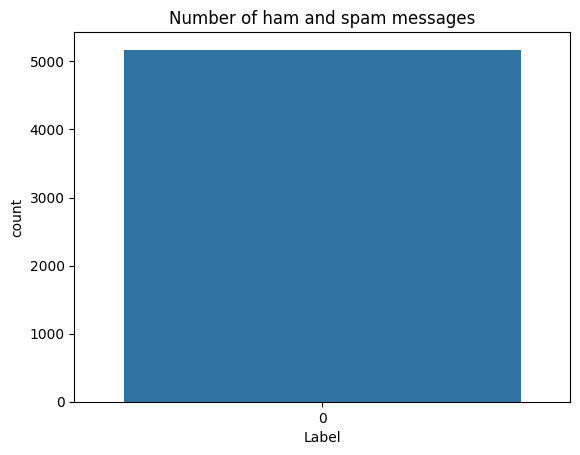

In [73]:
# bar plot label value counts  0 = non-spam, 1 = spam=
sns.countplot(df['label'])
plt.xlabel('Label')
plt.title('Number of ham and spam messages')

`NOTE`: The distribution of the labels is not balanced. There are 3672 non-spam emails and 1499 spam emails.

## Preprocessing
In this section, we will preprocess the data to make it ready for training.

We will perform the following preprocessing steps:
- Remove punctuation
- Convert the text to lowercase
- Remove stopwords
- Remove common words
- Remove rare words
- lemmatize the text

In [76]:
# remove punctuation
df['text'] = df['text'].str.replace('[^\w\s]','')
df.head()

/tmp/ipykernel_15319/2903461620.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  df['text'] = df['text'].str.replace('[^\w\s]','')


,label,text
0,0,Subject enron methanol meter 988291\r\nthis...
1,0,Subject hpl nom for january 9 2001\r\n see at...
2,0,Subject neon retreat\r\nho ho ho we re aroun...
3,1,Subject photoshop windows office cheap mai...
4,0,Subject re indian springs\r\nthis deal is to ...


In [77]:
# convert to lowercase
df['text'] = df['text'].str.lower()
df.head()

,label,text
0,0,subject enron methanol meter 988291\r\nthis...
1,0,subject hpl nom for january 9 2001\r\n see at...
2,0,subject neon retreat\r\nho ho ho we re aroun...
3,1,subject photoshop windows office cheap mai...
4,0,subject re indian springs\r\nthis deal is to ...


In [82]:
# remove stopwords
stop = stopwords.words('english')
df['text'] = df['text'].apply(lambda x: " ".join(x for x in x.split() if x not in stop))
df.head()

,label,text
0,0,subject enron methanol meter 988291 follow not...
1,0,subject hpl nom january 9 2001 see attached fi...
2,0,subject neon retreat ho ho ho around wonderful...
3,1,subject photoshop windows office cheap main tr...
4,0,subject indian springs deal book teco pvr reve...


In [83]:
# remove common words
freq = pd.Series(' '.join(df['text']).split()).value_counts()[:10]
freq = list(freq.index)
df['text'] = df['text'].apply(lambda x: " ".join(x for x in x.split() if x not in freq))
df.head()

,label,text
0,0,methanol meter 988291 follow note gave monday ...
1,0,hpl nom january 9 2001 see attached file hplno...
2,0,neon retreat ho ho ho around wonderful time ye...
3,1,photoshop windows office cheap main trending a...
4,0,indian springs deal book teco pvr revenue unde...


In [84]:
# remove rare words
freq = pd.Series(' '.join(df['text']).split()).value_counts()[-10:]
freq = list(freq.index)
df['text'] = df['text'].apply(lambda x: " ".join(x for x in x.split() if x not in freq))
df.head()

,label,text
0,0,methanol meter 988291 follow note gave monday ...
1,0,hpl nom january 9 2001 see attached file hplno...
2,0,neon retreat ho ho ho around wonderful time ye...
3,1,photoshop windows office cheap main trending a...
4,0,indian springs deal book teco pvr revenue unde...


In [86]:
# lemmatization
df['text'] = df['text'].apply(lambda x: " ".join([Word(word).lemmatize() for word in x.split()]))
df.head()


[nltk_data] Downloading package wordnet to /home/jovyan/nltk_data...


,label,text
0,0,methanol meter 988291 follow note gave monday ...
1,0,hpl nom january 9 2001 see attached file hplno...
2,0,neon retreat ho ho ho around wonderful time ye...
3,1,photoshop window office cheap main trending ab...
4,0,indian spring deal book teco pvr revenue under...


In [112]:
# show the first text
df['text'][0]

'methanol meter 988291 follow note gave monday 4 00 preliminary flow data provided daren override pop daily volume presently zero reflect daily activity obtain control change needed asap economics purpose'

## Feature Engineering
In this section, we will create features from the preprocessed text.

We will perform the following feature engineering steps:
- Vectorize the text using TF-IDF

In [88]:
# show the first text
df['text'][1]

'hpl nom january 9 2001 see attached file hplnol 09 xl hplnol 09 xl'

In [89]:
# vectorize the text
tfidf = TfidfVectorizer(max_features=1000, lowercase=True, analyzer='word', stop_words= 'english',ngram_range=(1,1))
tfidf.fit(df['text'])

X = tfidf.transform(df['text'])
y = df['label']


In [91]:
print(X.shape)
print(y.shape)

(5171, 1000)
(5171,)


## Splitting the dataset

In [115]:
# split the data into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")


X_train shape: (4136, 1000)
y_train shape: (4136,)
X_test shape: (1035, 1000)
y_test shape: (1035,)


## Model Training

In [123]:
# train the model
clf = MultinomialNB( alpha=1.0, fit_prior=True, class_prior=None)
clf.fit(X_train, y_train)

MultinomialNB()

## Model Evaluation

In [124]:
# predict the test data
y_pred = clf.predict(X_test)

In [125]:
# show the confusion matrix
confusion = confusion_matrix(y_test, y_pred)


Text(0.5, 1.0, 'Confusion Matrix')

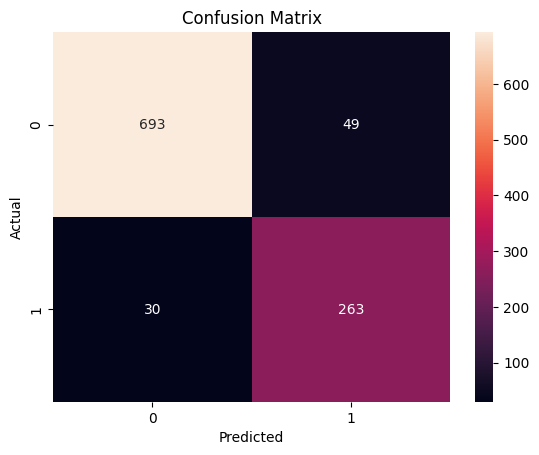

In [126]:
# plot the confusion matrix
sns.heatmap(confusion, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')


In [120]:
# show the classification report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.96      0.93      0.95       742
           1       0.84      0.90      0.87       293

    accuracy                           0.92      1035
   macro avg       0.90      0.92      0.91      1035
weighted avg       0.93      0.92      0.92      1035



In [121]:
# accuracy score in %
accuracy_score(y_test, y_pred) * 100


92.3671497584541

In [122]:
# rmse score
rms = sqrt(mean_squared_error(y_test, y_pred))
rms

0.27627613435738335